In [ ]:
KHANYILE  MS  22354752
MBUTHUMA  T   22329027
MFABA     NL  22335814
MNGUNI    N   22317612
NTSHANGASE M  22341705
XULU       OS 22222778

IMPORTING REQUIRED MODULES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

Setting style for plot

In [3]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

LOADING THE DATASETS

In [6]:
appointments = pd.read_csv("C:/Users/owami/Downloads/archive (3)/appointments.csv")
billing = pd.read_csv("C:/Users/owami/Downloads/archive (3)/billing.csv")
doctors = pd.read_csv("C:/Users/owami/Downloads/archive (3)/doctors.csv")
patients = pd.read_csv("C:/Users/owami/Downloads/archive (3)/patients.csv")

DATASET RELEVANCY AND LINK

This is a structured, multi-table dataset designed to simulate a hospital management system. It is ideal for practicing data analysis, SQL, machine learning, and healthcare analytics.The provided datasets are highly relevant for modeling historical healthcare utilization patterns within a specific hospital or clinic network. They contain valuable demographic details (age, gender, insurance type, location), healthcare usage information (appointments, billing, reasons for visits), and provider data (specializations, hospital branches, experience). Together, these features allow for accurate prediction of how many patients may visit general practitioners, specialists, or hospitals based on who the patients are, their medical history, and seasonal or temporal trends. In other words, the data is excellent for forecasting short-term demand and supporting operational planning within that healthcare system.

However, the datasets fall short of fully addressing the task of predicting demand under South Africa’s NHI system, which requires population-wide coverage. They miss key groups such as people who previously couldn’t afford care, those using public clinics or traditional healers, and those who might seek preventative services under NHI. Additionally, they lack population-level health indicators such as disease prevalence (HIV, TB, diabetes), socioeconomic factors, and mortality trends. Since the NHI will remove financial barriers and shift care-seeking behavior, true demand cannot be captured using these datasets alone. To address this, the framework built with the current data should be expanded by integrating external sources like Stats SA census data and Department of Health statistics. This demonstrates both solid technical modeling and awareness of the broader healthcare context. https://www.kaggle.com/datasets/kanakbaghel/hospital-management-dataset

Displaying basic info about each dataset

In [7]:
print("Appointments dataset shape:", appointments.shape)
print("Billing dataset shape:", billing.shape)
print("Doctors dataset shape:", doctors.shape)
print("Patients dataset shape:", patients.shape)


Appointments dataset shape: (200, 7)
Billing dataset shape: (200, 7)
Doctors dataset shape: (10, 8)
Patients dataset shape: (50, 11)


Checking for missing values

In [8]:
print("\nMissing values in appointments:")
print(appointments.isnull().sum())
print("\nMissing values in billing:")
print(billing.isnull().sum())
print("\nMissing values in doctors:")
print(doctors.isnull().sum())
print("\nMissing values in patients:")
print(patients.isnull().sum())


Missing values in appointments:
appointment_id      0
patient_id          0
doctor_id           0
appointment_date    0
appointment_time    0
reason_for_visit    0
status              0
dtype: int64

Missing values in billing:
bill_id           0
patient_id        0
treatment_id      0
bill_date         0
amount            0
payment_method    0
payment_status    0
dtype: int64

Missing values in doctors:
doctor_id           0
first_name          0
last_name           0
specialization      0
phone_number        0
years_experience    0
hospital_branch     0
email               0
dtype: int64

Missing values in patients:
patient_id            0
first_name            0
last_name             0
gender                0
date_of_birth         0
contact_number        0
address               0
registration_date     0
insurance_provider    0
insurance_number      0
email                 0
dtype: int64


Column names of each dataset

In [9]:
print("Appointments columns:", appointments.columns.tolist())
print("Billing columns:", billing.columns.tolist())
print("Patients columns:", patients.columns.tolist())
print("Doctors columns:", doctors.columns.tolist())


Appointments columns: ['appointment_id', 'patient_id', 'doctor_id', 'appointment_date', 'appointment_time', 'reason_for_visit', 'status']
Billing columns: ['bill_id', 'patient_id', 'treatment_id', 'bill_date', 'amount', 'payment_method', 'payment_status']
Patients columns: ['patient_id', 'first_name', 'last_name', 'gender', 'date_of_birth', 'contact_number', 'address', 'registration_date', 'insurance_provider', 'insurance_number', 'email']
Doctors columns: ['doctor_id', 'first_name', 'last_name', 'specialization', 'phone_number', 'years_experience', 'hospital_branch', 'email']


DATA PREPROCESSING

Creating heathcare_data to avoid merging errors

Step 1.Creating copy of Appointments

In [10]:
healthcare_data=appointments.copy()

Step 2. Adding patients information using mapping

In [11]:
patient_lookup = patients.set_index('patient_id')
for col in patients.columns:
    if col != 'patient_id':
        healthcare_data[col] = healthcare_data['patient_id'].map(patient_lookup[col])

Step 3. Adding doctors information using mapping

In [12]:
doctor_lookup = doctors.set_index('doctor_id')
for col in doctors.columns:
    if col != 'doctor_id':
        healthcare_data[col] = healthcare_data['doctor_id'].map(doctor_lookup[col])

print(f"Healthcare data created with shape: {healthcare_data.shape}")

Healthcare data created with shape: (200, 21)


Processing date columns and calculating age

In [13]:
healthcare_data['date_of_birth'] = pd.to_datetime(healthcare_data['date_of_birth'])
healthcare_data['appointment_date'] = pd.to_datetime(healthcare_data['appointment_date'])
healthcare_data['age'] = (healthcare_data['appointment_date'] - healthcare_data['date_of_birth']).dt.days // 365

Extracting time features

In [14]:
healthcare_data['appointment_month'] = healthcare_data['appointment_date'].dt.month
healthcare_data['appointment_day'] = healthcare_data['appointment_date'].dt.day
healthcare_data['appointment_dayofweek'] = healthcare_data['appointment_date'].dt.dayofweek
healthcare_data['appointment_year'] = healthcare_data['appointment_date'].dt.year

Adding seasons information

In [15]:
healthcare_data['season'] = healthcare_data['appointment_month'].apply(
    lambda x: 1 if x in [12, 1, 2] else (2 if x in [3, 4, 5] else (3 if x in [6, 7, 8] else 4))
)

Processing billing data separately

In [16]:
billing['bill_date'] = pd.to_datetime(billing['bill_date'])
patient_billing_stats = billing.groupby('patient_id').agg({
    'amount': ['sum', 'mean', 'count'],
    'payment_status': lambda x: (x == 'Paid').mean()
}).reset_index()

Flatten columns names

In [17]:
patient_billing_stats.columns = ['patient_id', 'total_billing', 'avg_billing', 'visit_count', 'payment_success_rate']

Merging billing with healthcare_data

In [18]:
healthcare_data = pd.merge(healthcare_data, patient_billing_stats, on='patient_id', how='left')

print(f"Final healthcare_data shape: {healthcare_data.shape}")
print("Columns:", healthcare_data.columns.tolist())

Final healthcare_data shape: (200, 31)
Columns: ['appointment_id', 'patient_id', 'doctor_id', 'appointment_date', 'appointment_time', 'reason_for_visit', 'status', 'first_name', 'last_name', 'gender', 'date_of_birth', 'contact_number', 'address', 'registration_date', 'insurance_provider', 'insurance_number', 'email', 'specialization', 'phone_number', 'years_experience', 'hospital_branch', 'age', 'appointment_month', 'appointment_day', 'appointment_dayofweek', 'appointment_year', 'season', 'total_billing', 'avg_billing', 'visit_count', 'payment_success_rate']


DATA VISUALIZATION

Appointment count by Specialization

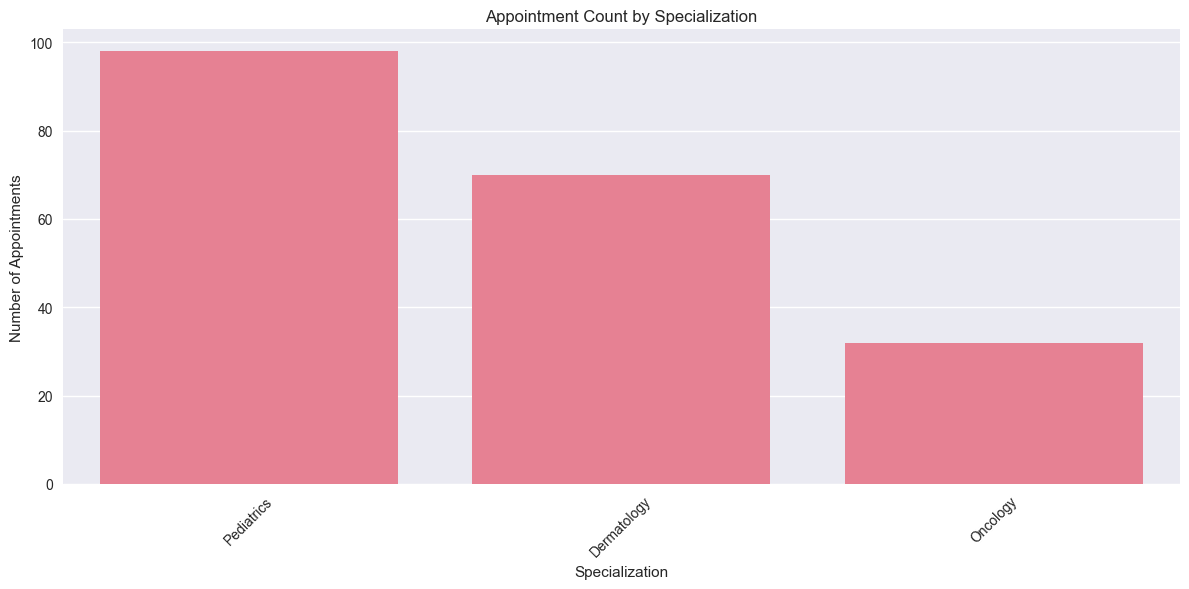

In [19]:
plt.figure(figsize=(12, 6))
specialization_counts = healthcare_data['specialization'].value_counts()
sns.barplot(x=specialization_counts.index, y=specialization_counts.values)
plt.title('Appointment Count by Specialization')
plt.xlabel('Specialization')
plt.ylabel('Number of Appointments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Appointment trends overtime

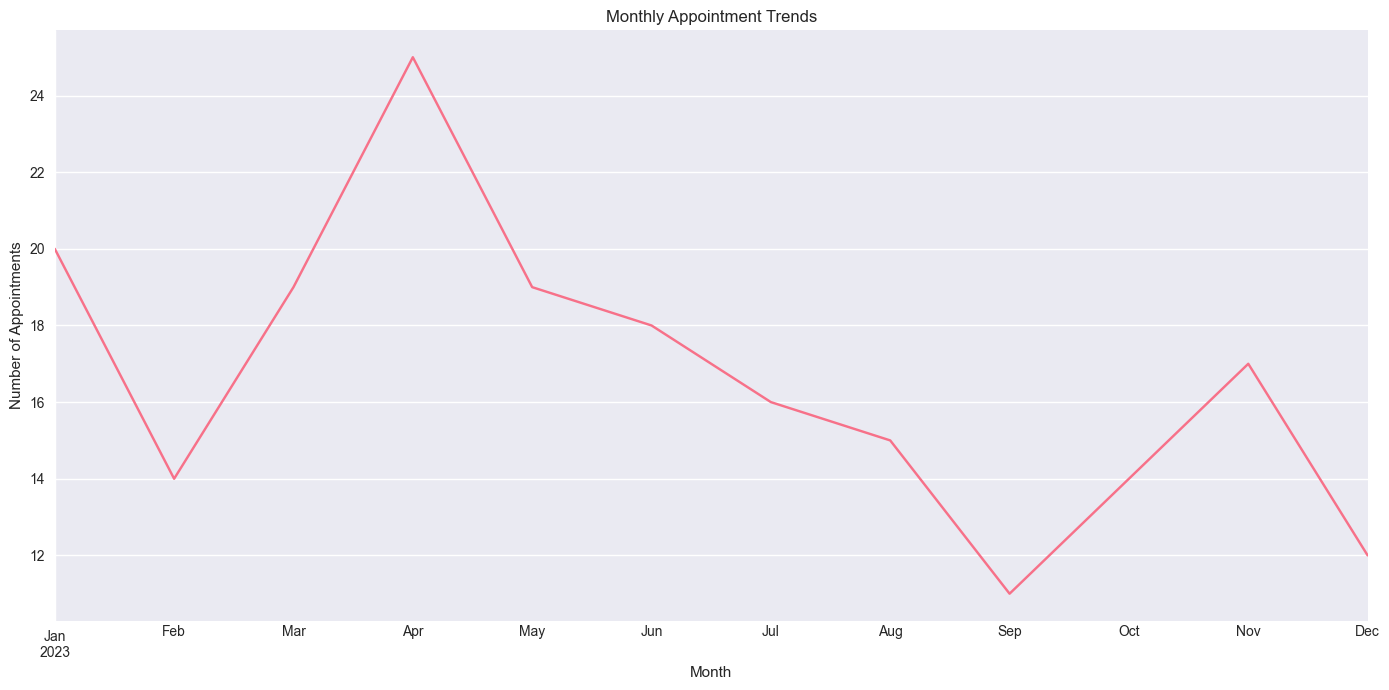

In [20]:
plt.figure(figsize=(14, 7))
monthly_appointments = healthcare_data.groupby(healthcare_data['appointment_date'].dt.to_period('M')).size()
monthly_appointments.plot()
plt.title('Monthly Appointment Trends')
plt.xlabel('Month')
plt.ylabel('Number of Appointments')
plt.grid(True)
plt.tight_layout()
plt.show()

Appointment distribution by day of week

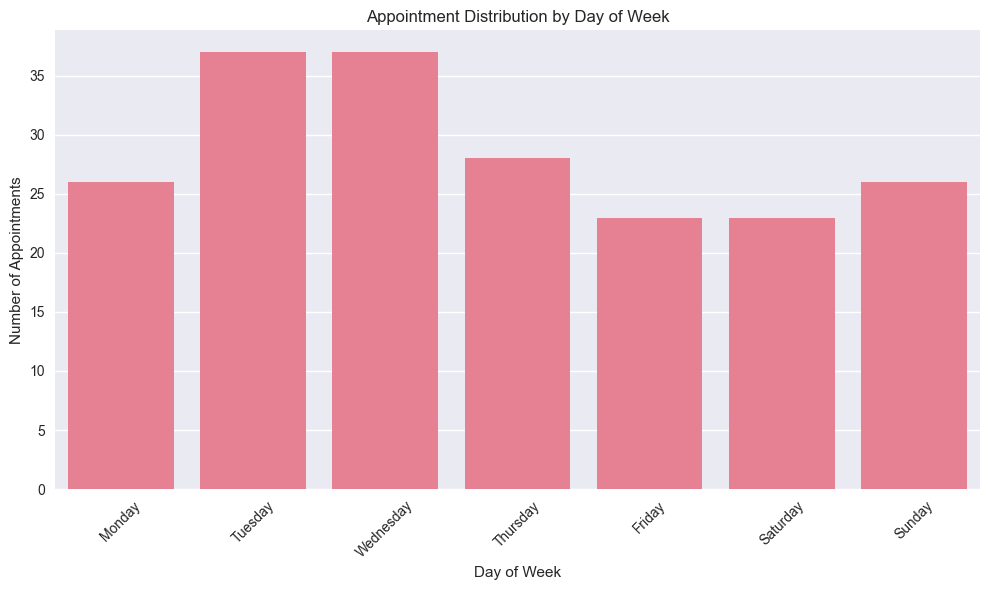

In [22]:
plt.figure(figsize=(10, 6))
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = healthcare_data['appointment_dayofweek'].value_counts().sort_index()
day_counts.index = day_names
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.title('Appointment Distribution by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Appointments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Age distribution of patients

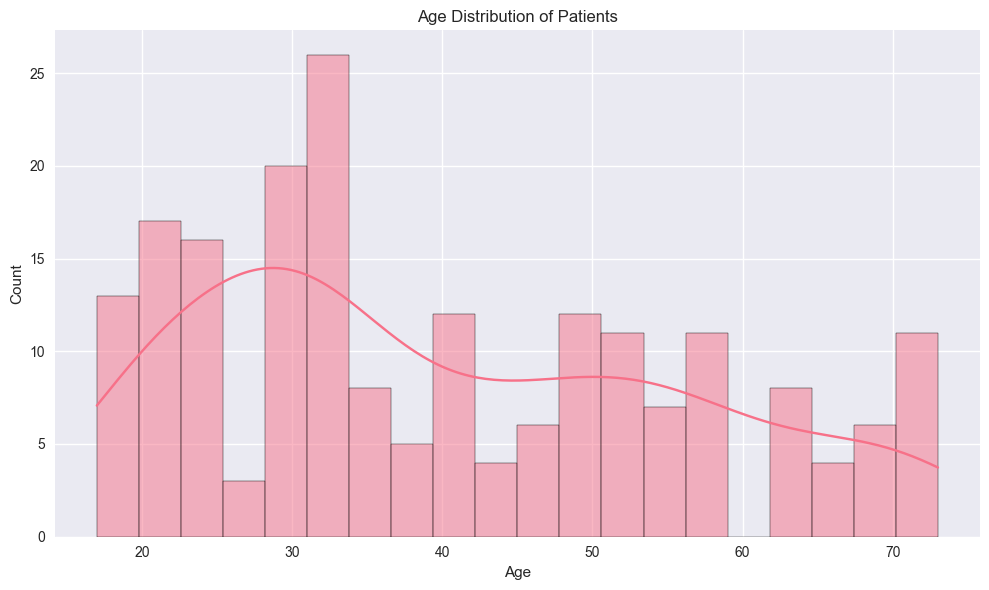

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(healthcare_data['age'], bins=20, kde=True)
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Heatmap of Appointment by specialization and month

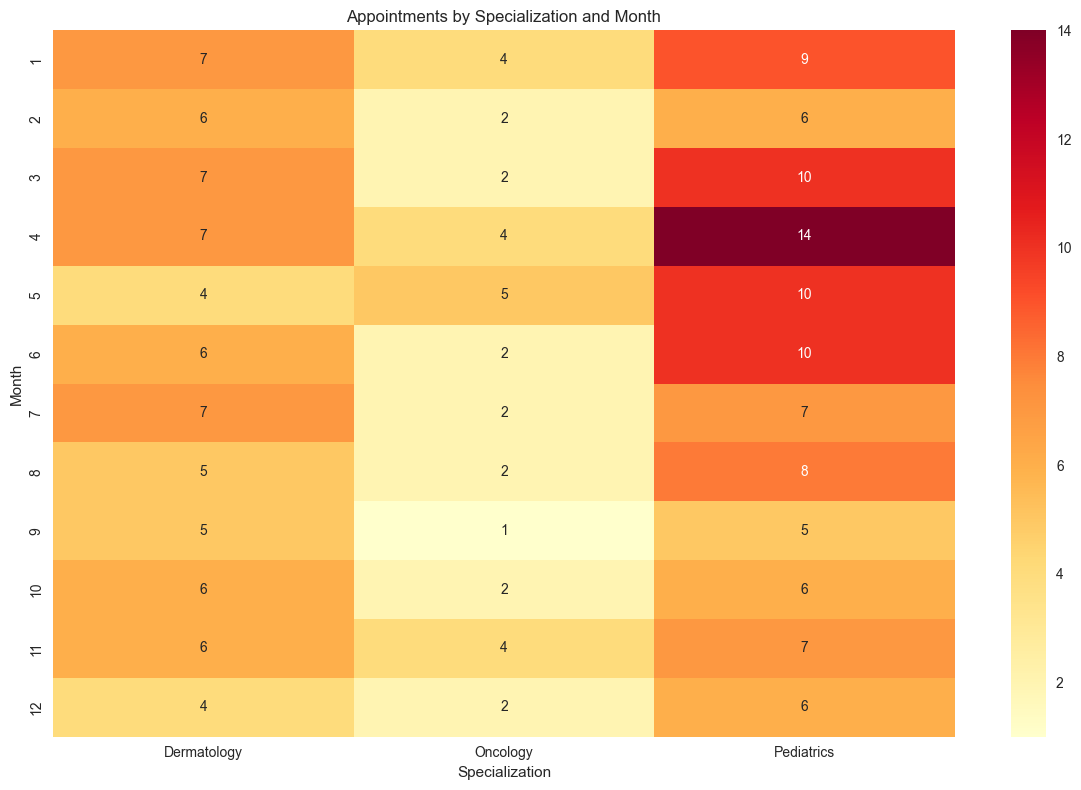

In [24]:
pivot_data = healthcare_data.pivot_table(
    index='appointment_month',
    columns='specialization',
    values='appointment_id',
    aggfunc='count'
)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, cmap='YlOrRd', annot=True, fmt='g')
plt.title('Appointments by Specialization and Month')
plt.xlabel('Specialization')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

Insurance provider distribution

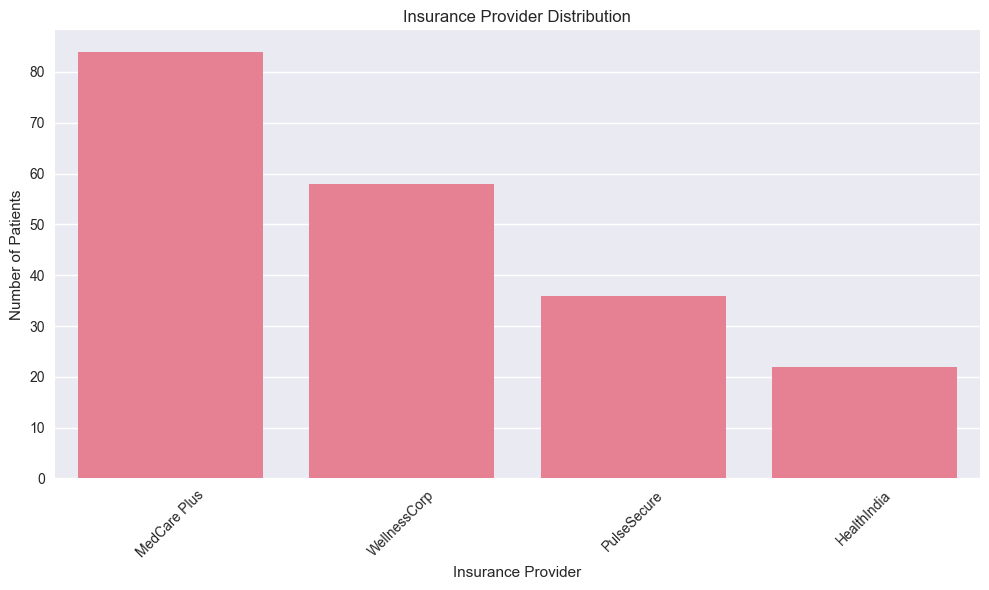

In [25]:
plt.figure(figsize=(10, 6))
insurance_counts = healthcare_data['insurance_provider'].value_counts()
sns.barplot(x=insurance_counts.index, y=insurance_counts.values)
plt.title('Insurance Provider Distribution')
plt.xlabel('Insurance Provider')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

MACHINE LEARNING IMPLEMENTATION

Creating dataset for predicting demand by speicialization and date

In [45]:
specialization_demand = healthcare_data.groupby(['specialization', 'appointment_date']).size().reset_index(name='appointment_count')

Adding features that migth influence demand

In [46]:
specialization_demand['day_of_week'] = pd.to_datetime(specialization_demand['appointment_date']).dt.dayofweek
specialization_demand['month'] = pd.to_datetime(specialization_demand['appointment_date']).dt.month
specialization_demand['is_weekend'] = specialization_demand['day_of_week'].isin([5, 6]).astype(int)
specialization_demand['season'] = specialization_demand['month'].apply(
    lambda x: 1 if x in [12, 1, 2] else (2 if x in [3, 4, 5] else (3 if x in [6, 7, 8] else 4))
)

Encoding speacilization

In [47]:
le = LabelEncoder()
specialization_demand['specialization_encoded'] = le.fit_transform(specialization_demand['specialization'])

Adding historical average appointment by speacilization and day of week

In [29]:
avg_appointments = healthcare_data.groupby(['specialization', 'appointment_dayofweek']).size().reset_index(name='avg_appointments')
specialization_demand = pd.merge(specialization_demand, avg_appointments,
                                left_on=['specialization', 'day_of_week'],
                                right_on=['specialization', 'appointment_dayofweek'],
                                how='left')

Adding previous appointments

In [31]:
specialization_demand = specialization_demand.sort_values(['specialization', 'appointment_date'])
specialization_demand['prev_period_appointments'] = specialization_demand.groupby('specialization')['appointment_count'].shift(1)
specialization_demand['prev_period_appointments'].fillna(specialization_demand['prev_period_appointments'].mean(), inplace=True)

Preparing features and targets

In [32]:
X = specialization_demand[['specialization_encoded', 'day_of_week', 'month',
                          'is_weekend', 'season', 'avg_appointments', 'prev_period_appointments']]
y = specialization_demand['appointment_count']

Handling any missing values

In [33]:
X = X.fillna(X.mean())

Splitting the data

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Scaling the features

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Initializing ,training and make predictions

In [36]:
print("Training Random Forest model...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

Training Random Forest model...


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [37]:
y_pred = model.predict(X_test_scaled)
print("random forest Results")
print("accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

random forest Results
accuracy : 0.8108108108108109
              precision    recall  f1-score   support

           1       0.81      1.00      0.90        30
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         1

    accuracy                           0.81        37
   macro avg       0.27      0.33      0.30        37
weighted avg       0.66      0.81      0.73        37



Logistic regression

In [39]:
logreg= LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [40]:
y_pred_logreg = logreg.predict(X_test_scaled)
print("logistic regression Results")
print("accuracy :", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

logistic regression Results
accuracy : 0.8108108108108109
              precision    recall  f1-score   support

           1       0.81      1.00      0.90        30
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         1

    accuracy                           0.81        37
   macro avg       0.27      0.33      0.30        37
weighted avg       0.66      0.81      0.73        37



Evaluating the model

In [41]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


print(f"Model Evaluation:")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

Model Evaluation:
Root Mean Squared Error: 0.52
R-squared: -0.21


Feature importance

In [42]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                    feature  importance
2                     month    0.419732
1               day_of_week    0.162650
5          avg_appointments    0.161523
4                    season    0.130123
0    specialization_encoded    0.075086
6  prev_period_appointments    0.039420
3                is_weekend    0.011467


[lotting feature importance

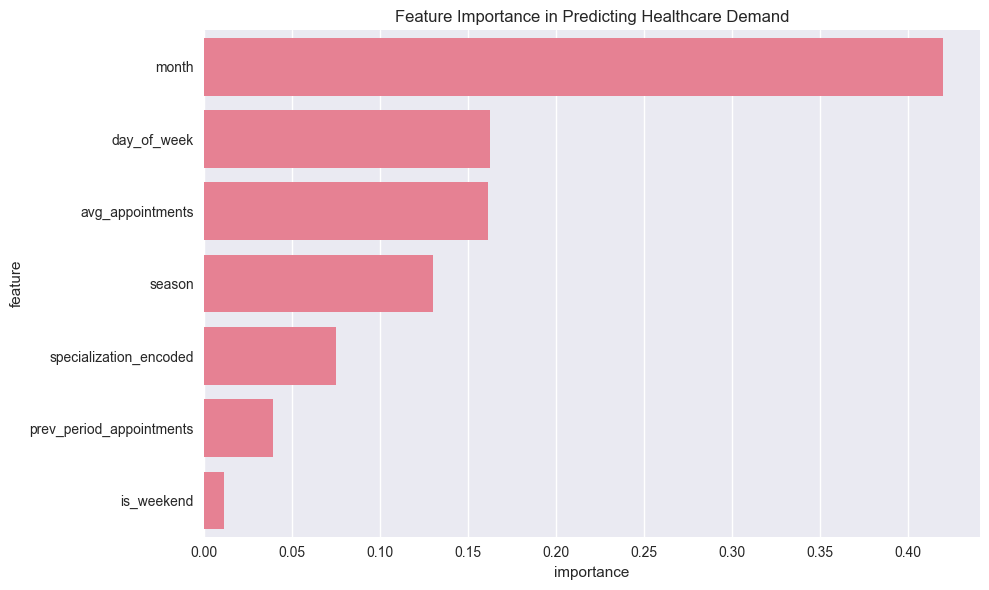

In [43]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Predicting Healthcare Demand')
plt.tight_layout()
plt.show()

Comparing actual VS Predicted values

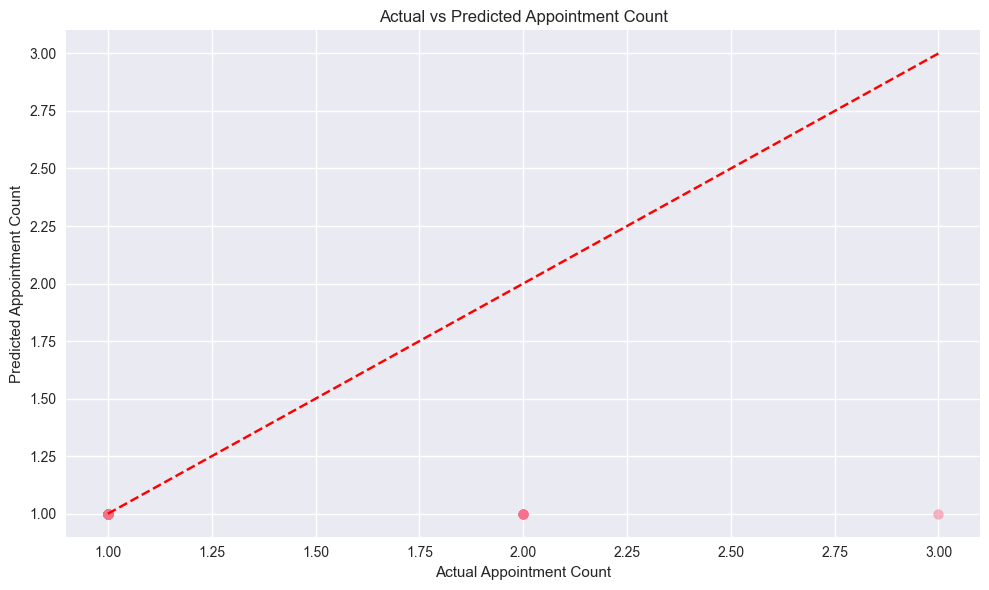

In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Appointment Count')
plt.ylabel('Predicted Appointment Count')
plt.title('Actual vs Predicted Appointment Count')
plt.tight_layout()
plt.show()